# Denoising Diffusion Models

<p>
CAS on Advanced Machine Learning <br>
Data Science Lab, University of Bern, 2023<br>
Prepared by Dr. Mykhailo Vladymyrov.

</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.
Based on the HuggingFace tutorials and reference manual

# Libs installation

In [ ]:
pip install transformers diffusers accelerate einops datasets

# Load libs and utils

In [3]:
from dataclasses import dataclass
import einops as eo

import math
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
import os

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F

from torchvision import transforms

from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

from datasets import load_dataset


from accelerate import Accelerator

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def is_iterable(obj):
    if type(obj) == str:
      return False
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def plot_many(ys, xs=None, labels=None, xlabels=None, ylabels=None, titles=None, legend_loc='best', single_plot_sz=6):
    """
    plot many lines in one plot
    """
    n_plots = len(ys)

    def prep_for_n_plots(var, n_plots):
        if var is None:
            return [None] * n_plots
        elif is_iterable(var):
            assert len(var) == n_plots, f'len({var}) != {n_plots}'
            return var
        else:
            return [var] * n_plots

    xs = prep_for_n_plots(xs, n_plots)
    labels = prep_for_n_plots(labels, n_plots)
    xlabels = prep_for_n_plots(xlabels, n_plots)
    ylabels = prep_for_n_plots(ylabels, n_plots)
    titles = prep_for_n_plots(titles, n_plots)
    legend_loc = prep_for_n_plots(legend_loc, n_plots)

    if not is_iterable(single_plot_sz):
        single_plot_sz = [single_plot_sz, single_plot_sz]

    figsize = [single_plot_sz[0] * n_plots, single_plot_sz[1]]

    fig, ax = plt.subplots(nrows=1, ncols=n_plots, figsize=figsize)

    if n_plots==1:
      ax = [ax]

    for axi, x, y, label, xlabel, ylabel, title, loc in zip(ax, xs, ys, labels, xlabels, ylabels, titles, legend_loc):
        if y is None:
            # placeholder for empty plot - to be filled by the caller
            continue

        if is_iterable(y[0]):
            n = len(y)
            x = prep_for_n_plots(x, n)
            label = prep_for_n_plots(label, n)

            for xi, yi, labeli in zip(x, y, label):
                if xi is None:
                  axi.plot(yi, label=labeli)
                else:
                  axi.plot(xi, yi, label=labeli)
            axi.legend(loc=loc)
        else:
            if x is None:
              axi.plot(y, label=label)
            else:
              axi.plot(x, y, label=label)
        axi.set_xlabel(xlabel)
        axi.set_ylabel(ylabel)
        axi.set_title(title)

    return fig, ax

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # use first available GPU
    else:
        device = torch.device('cpu')
    return device

In [5]:
device = get_device()
device

device(type='cuda', index=0)

# 1. Train Diffusion Model: butterflies dataset

comlpete the code to make it work

In [ ]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [6]:
# inspect the `dataset`.
# what are the elements of `dataset['images']` array?

In [ ]:
raw_sz = # find max dimension of the samples

In [ ]:
# it is convenient to store configurations as `dataclass`
@dataclass
class TrainingConfig:
    raw_size = raw_sz
    dataset_name = dataset_name
    image_size = 32  # the generated image resolution  - keep it small for fast training
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 150
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-32"

    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 2023


config = TrainingConfig()

In [ ]:
def to_np_showable(pt_img):
  np_im = # convert pt_img to numpy format
  if len(np_im.shape) == 4:
    np_im = np_im[0]

  if np_im.shape[0] > 3:
    np_im = np_im[-3:]

  return (eo.rearrange(np_im, 'c h w -> h w c')/2+.5).clip(0., 1.)

def plot_im(im, is_torch=True):
  plt.imshow(to_np_showable(im) if ...   # complete the line
  plt.show()
  plt.close()

def plot_im_samples(ds, col, n=5, is_torch=False):
  fig, axs = plt.subplots(1, n, figsize=(16, n))
  for i, image in enumerate(ds[:n][col]):
      axs[i].imshow(to_np_showable(image) if is_torch else image)
      axs[i].set_axis_off()
  plt.show()
  plt.close()

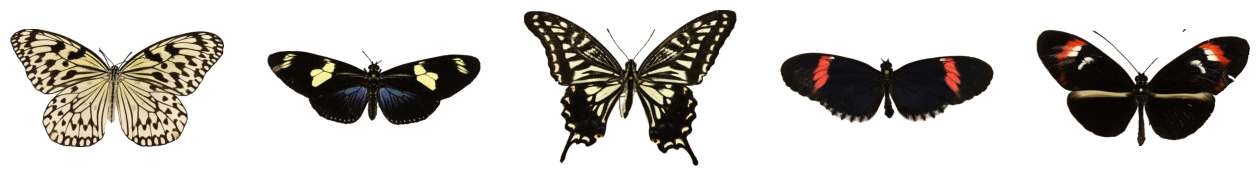

In [ ]:
# use `plot_im_samples` to visualize column 'image' in the `dataset`

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.RandomCrop(config.raw_size, pad_if_needed=True, fill=255.),
        transforms.Resize # resize to the input image size given in the config file
        ???,  # at random apply the horizontal flip to the samples
        ???,  # convert to the torch tensor
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

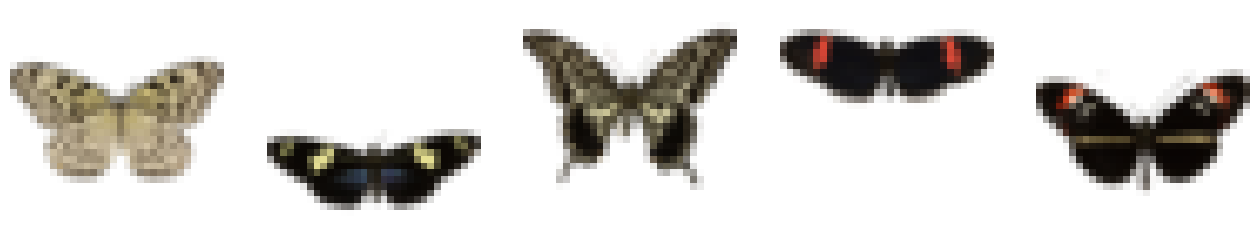

In [ ]:
# visualize the dataset again, after applying the transformation.
# What has to be changed?
# Does what you see agree with what you expect to see?

In [ ]:
train_dataloader = # create data loader with the batch size given in the config

In [ ]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=6,  # the number of input channels, 3 for RGB images
    out_channels=6,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, ???, 256),  # fill the missing number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


## Inspect U-Net

Verify that U-Net output size matched the input:
1. generate noisy sample
2. pass through the model
3. compare input and output sizes.

What parameters is the model expecting as input?

## Scheduler

In [ ]:
# take one sample
sample_image = dataset[0]["images"].unsqueeze(0)

Input shape: torch.Size([1, 6, 32, 32])
Output shape: torch.Size([1, 6, 32, 32])


inspect how samlple looks after 5, 20, 80, 320 diffusion steps

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = ....  # random noise tensor
diffusion_step_idx = ... #
timestep = torch.LongTensor([diffusion_step_idx])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timestep)

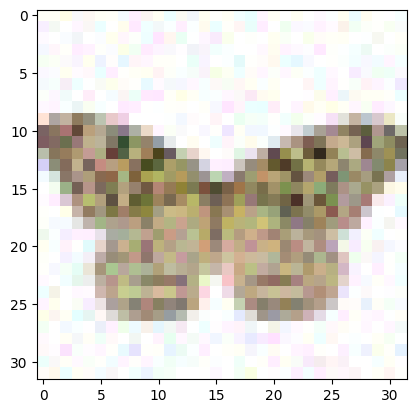

In [ ]:
plot_im(noisy_image)

In [ ]:
# what does model predict?
.... = model(noisy_image, timesteps).sample

# what does the loss compare to what?
loss = F.mse_loss(

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=  # number of elements in data loder times numebr of epochs
)

In [ ]:
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        output_type = 'np.array'
    ).images

    # Make a grid out of the images
    images = pipeline.numpy_to_pil(images[..., -3:])
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

go carefully through the lines and understand what is going on

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything - allows for easy distributed training.
    # merging results should happen under `if accelerator.is_main_process`
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

# oaarameters to the train loop
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=2)

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [7]:
%load_ext tensorboard

In [11]:
#! ps | grep tensorboard
# !kill xxxx

In [ ]:
%tensorboard --logdir /content/ddpm-butterflies-32/logs

# 2. Train Latent Diffusion Model

Save and stop this notebook.

Then :
1. Train a Fully Convolutional (no flattening) autoencoder to create low-dimensional butterfly embedding ((3, 512, 512)  -> (32, 16, 16)). Save the trained model on your google drive
2. Save dataset of latent representations (see the AE notebook)
3. Adapt this filled notebook to a) 32 instead of 3 channels; b) saved dataset instead of the butterfly one.
4. Train the LDM till convergence, and save on the google drive. How do you monitor convergence?
5. Generate 16 samples.
6. Pass them through the decoder model.
